In [1]:
import math
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
import os 

import laplace

In [2]:
%config InlineBackend.figure_format = 'retina'
sns.set(style="darkgrid")
matplotlib.rcParams['figure.dpi']= 200
sns.set(style="white")

# Bayesian Linear Regression

In [3]:
import numpy as np


def func(x):
    return np.sin(2 * np.pi * x)


size = 200 
rng = np.random.RandomState(1234)
x_train = rng.uniform(0.0, 1.0, size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0.0, 1.0, 100)


In [4]:
'''def func(x):
    return np.sin(2 * np.pi * x ** 2) - np.tan(x)


size = 200
rng = np.random.RandomState(1234)
x_train = rng.uniform(0.0, 1.0, size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0.0, 1.0, 100)'''

'def func(x):\n    return np.sin(2 * np.pi * x ** 2) - np.tan(x)\n\n\nsize = 200\nrng = np.random.RandomState(1234)\nx_train = rng.uniform(0.0, 1.0, size)\ny_train = func(x_train) + rng.normal(scale=0.1, size=size)\nx_test = np.linspace(0.0, 1.0, 100)'

In [5]:
from sklearn.linear_model import BayesianRidge

n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)

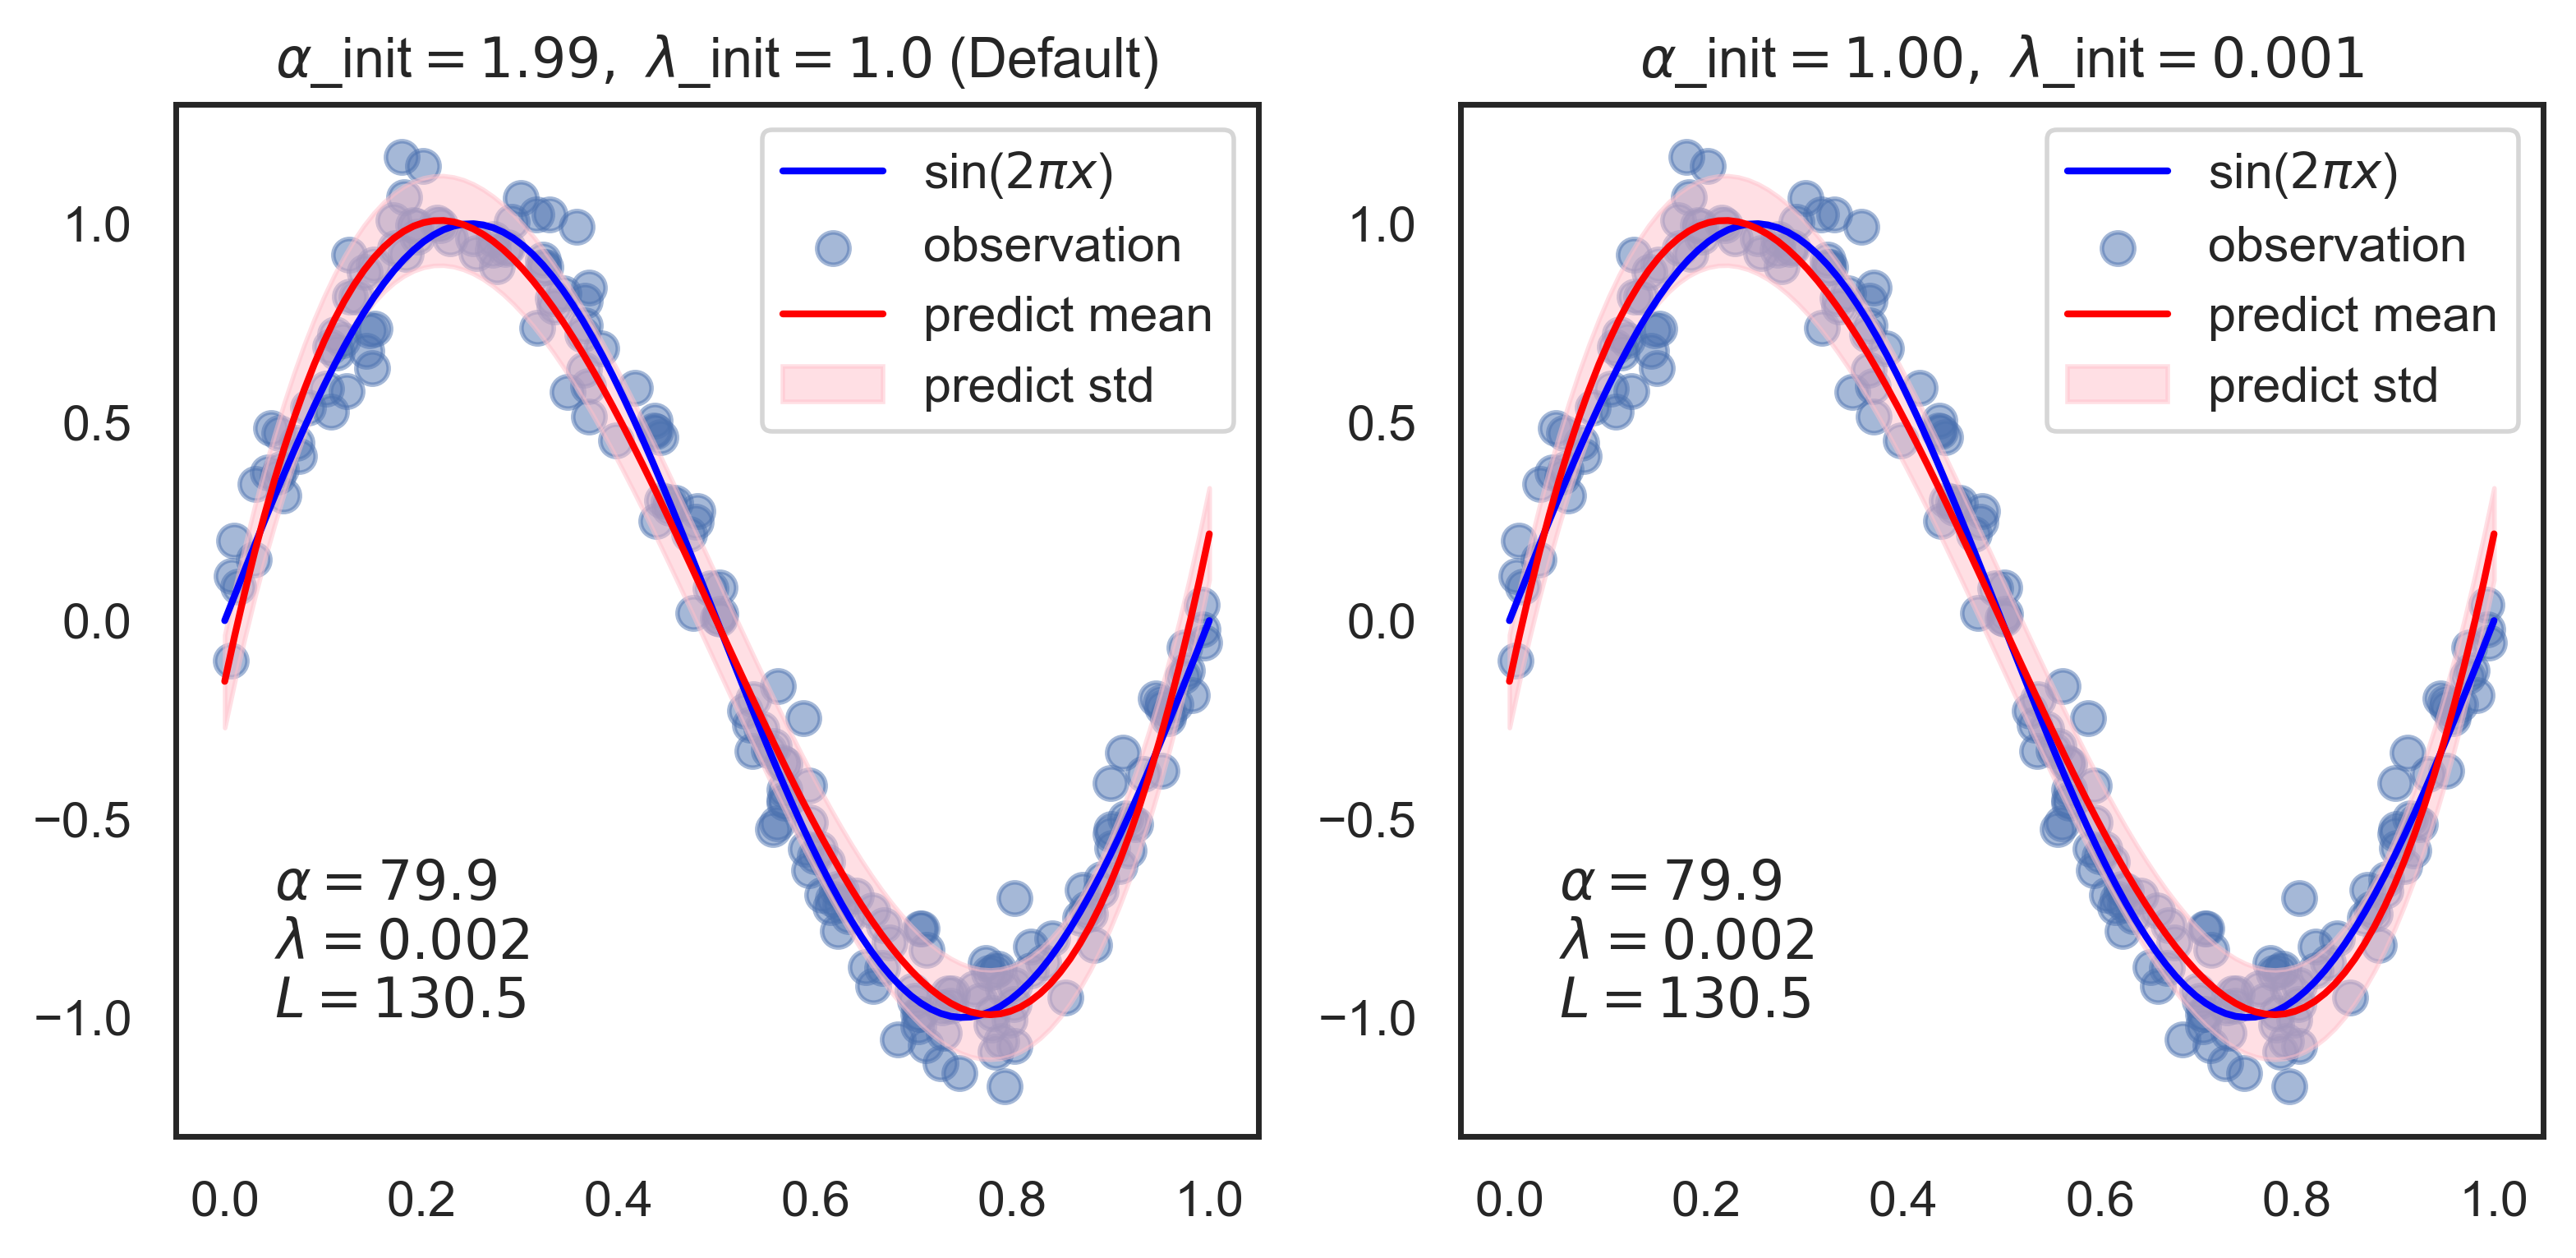

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.0]  # Default values
    elif i == 1:
        init = [1.0, 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(
        x_test, ymean - ystd, ymean + ystd, color="pink", alpha=0.5, label="predict std"
    )
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
        reg.alpha_, reg.lambda_, reg.scores_[-1]
    )
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()

# SVGD and SVN implementations

In [7]:
import torch
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, x, y):
        # Convert the numpy arrays to PyTorch tensors
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        # Return the size of the dataset
        return len(self.x)

    def __getitem__(self, idx):
        # Retrieve an item by index
        return self.x[idx], self.y[idx]

In [8]:
import matplotlib.pyplot as plt

def plot_functions(x_test, ensemble, func):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for i, ax in enumerate(axes):
        
        
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)

        y_ensemble = ensemble.forward(x_test_tensor)

        # Calculate mean and std of predictions
        y_mean = torch.mean(y_ensemble[0], dim=0).squeeze()  # Mean across particles
        y_std = torch.std(y_ensemble[0], dim=0).squeeze()  # Std deviation across particles
        
        ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
        ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
        
        ax.plot(x_test_tensor, y_mean, color="red", label="predict mean")

        # Plot ensemble predictions
        for i in range(y_ensemble[0].shape[0]):
            ax.plot(x_test, y_ensemble[0][i].numpy().squeeze(), linestyle='--', alpha=0.5, label=f"Member {i+1}")


        ax.fill_between(
            x_test, y_mean - y_std, y_mean + y_std, color="pink", alpha=0.5, label="predict std"
        )
        #ax.set_ylim(-1.3, 1.3)
        ax.legend()
        title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
        if i == 0:
            title += " (Default)"
        ax.set_title(title, fontsize=12)
        text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
            reg.alpha_, reg.lambda_, reg.scores_[-1]
        )
        ax.text(0.05, -1.0, text, fontsize=12)

    plt.tight_layout()
    plt.show()

In [17]:
import torch.nn.functional as F

from utils.ensemble import Ensemble
from utils.kernel import RBF
from models.mlp import Net 
from train.train_svgd import train


# Creating an instance of the SineDataset
sine_dataset = Dataset(x_train, y_train)


layer_sizes = [1, 1]

print("layer sizes: ", layer_sizes)

#mnet = Net(layer_sizes, classification = False, act=F.relu, out_act = F.softmax, bias = True ).to(device)
mnet = Net(layer_sizes, classification = False, act=F.relu, out_act = None, bias = True ).to(device)
#input_size = 1  # Because each input data point has 1 feature
#output_size = 1  # Assuming you're predicting a single value

print("parameters in Net: ", mnet.num_params)
#print([p for p in mnet.parameters()])

n_particles = 3

ensemble = Ensemble(device = device, net=mnet, n_particles = n_particles)

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Split the data into training and evaluation sets
x_train_split, x_eval_split, y_train_split, y_eval_split = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Create instances of the SineDataset for each set
train_dataset = Dataset(x_train_split, y_train_split)
eval_dataset = Dataset(x_eval_split, y_eval_split)


# Creating a DataLoaders
batch_size = 4  # Define your batch size
shuffle = False  # Shuffle the data every epoch
num_workers = 1  # How many subprocesses to use for data loading

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

K = RBF(0.01)
lr = 1e-4

num_epochs = 5
metrics = train(ensemble, lr, num_epochs, train_dataloader, eval_dataloader, device, use_SVN=True)

plot_functions(x_test, ensemble, func)


layer sizes:  [1, 1]
parameters in Net:  2
initialised particles:  torch.Size([3, 2])
W shape before training:  torch.Size([3, 2])
-------------------------Start training-------------------------
Epoch 0


  0%|          | 0/40 [00:00<?, ?it/s]

length X 4
length dataloader 4
W tensor([[ 0.7205, -0.1121],
        [-0.0309, -0.1503],
        [ 1.8928,  1.3067]], requires_grad=True)
[Parameter containing:
tensor([[0.2229]], requires_grad=True), Parameter containing:
tensor([-0.5533], requires_grad=True)]


TypeError: object of type 'NoneType' has no len()